# DIFFERENTIAL ABUNDANCE TESTING
We are interested in checking whether there exists a number of ARG/MGE sequences that, while present in both control and plastic samples, can be inferred to be differentially abundant in either plastics or soils.

This means first finding which sequences are present in the same area and in both plastics and soils (otherwise, comparisions wouldn't make much sense). Then, running a multiple comparisions test, like Kruskal Wallis, to see whether there are differences. And in the case of there being, see if any single (or any group of) are still statistically different once p-values are corrected.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import scikit_posthocs as sp
import matplotlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.chdir("../data/clean_data") #data directory
data_dir = os.getcwd()
os.chdir("../../results/DA_res")
da_dir = os.getcwd()

If I filter out those samples that haven't amplified, I'm losing out on valuable information when it comes to making the comparisions, as the lack of amplification in this case does interest us. However, it makes finding common (plastic + soil) amplified sequences easier

In [3]:
os.chdir(data_dir)
all_data = pd.read_csv("ab_data_all_fixed.csv", index_col = 0)
all_data.dropna(inplace = True)
all_data = all_data[(all_data["antib"] != "16S")]
all_data = all_data[["Assay", "antib", "sample", "place", "type_f", "type_g", "or_seq", "rel_ab"]] 
all_data = all_data.loc[~all_data["place"].isin([0])]
all_data.loc[all_data["sample"] == 13, "rel_ab"] = all_data.loc[all_data["sample"] == 13]["rel_ab"] / 3
all_data.loc[all_data["sample"] == 14, "rel_ab"] = all_data.loc[all_data["sample"] == 14]["rel_ab"] / 3

In [4]:
# Couple of miscellaneous fixes
# Fix a misclassification
all_data.loc[all_data["antib"] == "Phenicol", "antib"] = "Amphenicol"

# Fix a bunch of badly assigned resistances 
all_data.loc[all_data["antib"] == "Other", "or_seq"] = "arg"
all_data.loc[all_data["Assay"] == "dfrA1", "antib"] = "Trimethoprim"
all_data.loc[all_data["Assay"] == "dfrA12", "antib"] = "Trimethoprim"
all_data.loc[all_data["Assay"] == "dfrA1", "or_seq"] = "arg"
all_data.loc[all_data["Assay"] == "dfrA12", "or_seq"] = "arg"
all_data.loc[all_data["antib"] == "Plasmid-inc", "antib"] = "Plasmid"
all_data.loc[all_data["antib"] == "Plasmid-rep", "antib"] = "Plasmid"

In [5]:
common_amps = all_data[["Assay", "place", "type_g"]].groupby(["place", "Assay"])["type_g"].unique()
common_amps = common_amps.reset_index()
common_amps["type_g"] = common_amps["type_g"].astype("str") #hacky as shit
common_amps = common_amps.loc[(common_amps["type_g"] == "['plastic' 'control']") | (common_amps["type_g"] == "['control' 'plastic']")]
common_amps

,place,Assay,type_g
0,ardley,ARR-3,['plastic' 'control']
1,ardley,Aac6-Aph2,['plastic' 'control']
3,ardley,Arr2,['plastic' 'control']
6,ardley,IS1133,['plastic' 'control']
7,ardley,IS1247,['plastic' 'control']
...,...,...,...
422,uru,mphA,['control' 'plastic']
423,uru,oprD,['plastic' 'control']
424,uru,orf37-IS26,['plastic' 'control']
426,uru,qepA_1_2,['plastic' 'control']


In [6]:
fixed_all = pd.DataFrame()
for sam_area in all_data["place"].unique():
    print("Working on: ", sam_area)
    sam_area_data = all_data.loc[all_data["place"] == sam_area]
    sam_area_data = sam_area_data.loc[sam_area_data["Assay"]
                                      .isin(list(common_amps.loc[common_amps["place"] == sam_area]["Assay"]
                                                 .unique()
                                                )
                                           )
                                     ]
    print("There's: ", len(sam_area_data["Assay"].unique()), "unique SHARED amps in ", sam_area)
    fixed_all = pd.concat([sam_area_data, fixed_all])
    del(sam_area_data)
fixed_all

Working on:  ardley
There's:  235 unique SHARED amps in  ardley
Working on:  ion
There's:  11 unique SHARED amps in  ion
Working on:  uru
There's:  15 unique SHARED amps in  uru


,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab
4259,aac3-Via,Aminoglycoside,7.0,uru,EPS,plastic,arg,0.009441
4366,oprD,MDR,7.0,uru,EPS,plastic,arg,0.000264
4376,mexB,MDR,7.0,uru,EPS,plastic,arg,0.000343
4377,mdtg,MDR,7.0,uru,EPS,plastic,arg,0.000455
4501,intI1F165_clinical,Integrase,7.0,uru,EPS,plastic,mge,0.002183
...,...,...,...,...,...,...,...,...
3419,tnpAg,Transposase,21.0,ardley,soil,control,mge,0.000647
3424,dfra21,Trimethoprim,21.0,ardley,soil,control,arg,0.089125
3427,dfrA10,Trimethoprim,21.0,ardley,soil,control,arg,0.013428
3433,dfrAB4,Trimethoprim,21.0,ardley,soil,control,arg,0.000095


In [7]:
# I start innovating from here
ard_seqs = list(fixed_all.loc[fixed_all["place"] == "ardley"]["Assay"].unique())
uru_seqs = list(fixed_all.loc[fixed_all["place"] == "uru"]["Assay"].unique())
ion_seqs = list(fixed_all.loc[fixed_all["place"] == "ion"]["Assay"].unique())

In [8]:
# Go back, this time keep all the data
all_data = pd.read_csv("ab_data_all_fixed.csv", index_col = 0)
all_data.fillna(0, inplace = True)
all_data = all_data[(all_data["antib"] != "16S")]
all_data = all_data[["Assay", "antib", "sample", "place", "type_f", "type_g", "or_seq", "rel_ab"]] #place viene a ser la estrella del show
all_data = all_data.loc[~all_data["place"].isin([0])]
all_data.loc[all_data["sample"] == 13, "rel_ab"] = all_data.loc[all_data["sample"] == 13]["rel_ab"] / 3
all_data.loc[all_data["sample"] == 14, "rel_ab"] = all_data.loc[all_data["sample"] == 14]["rel_ab"] / 3
#all_data = all_data[(all_data.Assay != "aadA7") & (all_data.sample != 5)] #esto también es tremendamente importante

os.chdir(da_dir)
all_data

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab
0,aacC2,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000222
1,aacA/aphD,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000046
2,aac(6')-II,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.006918
3,aphA3,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000000
4,sat4,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000000
...,...,...,...,...,...,...,...,...
10309,dfrAB4,Trimethoprim,14.0,ion,water,control,arg,0.000000
10310,dfrC,Trimethoprim,14.0,ion,water,control,arg,0.000000
10311,dfrG,Trimethoprim,14.0,ion,water,control,arg,0.000000
10312,dfrK,Trimethoprim,14.0,ion,water,control,arg,0.000000


In [9]:
def_data = all_data.loc[((all_data["place"] == "ardley") & all_data["Assay"].isin(ard_seqs)) | 
((all_data["place"] == "uru") & all_data["Assay"].isin(uru_seqs)) | 
((all_data["place"] == "ion") & all_data["Assay"].isin(ion_seqs))]

def_data

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab
0,aacC2,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000222
6,aadA2a,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.015205
7,aadA5,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.002472
8,aadA_99,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.004207
10,aadD,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.002742
...,...,...,...,...,...,...,...,...
10231,intI1F165_clinical,Integrase,14.0,ion,water,control,mge,0.000391
10232,intl3,Integrase,14.0,ion,water,control,mge,0.000000
10240,czcA,MDR,14.0,ion,water,control,arg,0.004148
10272,trb-C,Plasmid,14.0,ion,water,control,mge,0.000128


## ALL DATA CONSIDERED AT ONCE
The first thing we're considering is which ARG / MGE are differentially abundant when considering all samples at once

In [10]:
for or_seq in def_data["or_seq"].unique():
    # Separate ARG from MGE
    seq_data = def_data.loc[def_data["or_seq"] == or_seq]
    sp_grouped = seq_data.groupby(["Assay", "type_g"])
    # Agg data to compare
    var_lst = [group["rel_ab"] for name, group in sp_grouped]
    nam_lst = [name for name, group in sp_grouped]
    # Run posthocs
    post = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")
    post.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post.columns, nam_lst)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post.index, nam_lst)},
                 inplace = True)
    # Turn results into a melted df 
    #post = post[post < 0.05] # It's better to keep alL the info and filter it afterwards than losing it here
    post_control = post.iloc[0:post.shape[0]:2,1:(post.shape[1]+1):2]
    post_diag = pd.Series(np.diag(post_control), index=[post_control.index, post_control.columns])
    significant_res = post_diag[~np.isnan(post_diag)]
    significant_res = significant_res.reset_index()
    # Calculate the difference in NCN to see in which typology (plastic vs surrounding env) are the DA samples 
    da_seqs = [val[0] for val in significant_res["level_0"]] # Keep only DA samples
    difs = seq_data.loc[seq_data["Assay"].isin(da_seqs)]
    difs_grouped = difs.groupby(["Assay", "type_g"])
    difs_summed = difs_grouped["rel_ab"].sum()
    difs_summed = difs_summed.reset_index()
    pdata = difs_summed[(difs_summed["type_g"] == "plastic")].reset_index()
    cdata = difs_summed[(difs_summed["type_g"] == "control")].reset_index()
    difs = pdata["rel_ab"] - cdata["rel_ab"]
    difs.index = pdata["Assay"]
    difs = difs.reset_index()
    significant_res["Assay"] = da_seqs
    significant_res.rename(columns = {0: "adjusted_pvals"}, inplace = True)

    difs = difs.merge(significant_res, on = "Assay")
    difs.rename(columns = {"rel_ab": "difference_in_ncn"}, inplace = True)
    difs.drop(columns = ["level_0", "level_1"], inplace = True)
    difs["log2_dif"] = np.log2(difs["difference_in_ncn"] + 1) # we need the log2 to study log2foldchanges
    difs["log2foldchange_in"] = "neither"
    difs.loc[difs["difference_in_ncn"] >= 1, "log2foldchange_in"] = "plastic"
    difs.loc[difs["difference_in_ncn"] <= -1, "log2foldchange_in"] = "surrounding_env"

    difs["da"] = "FALSE"
    difs.loc[(difs["log2foldchange_in"] != "neither") & (difs["adjusted_pvals"] < 0.05), "da"] = "TRUE"
    
    # And put it all together
    antib_ref = all_data[["antib", "Assay"]] #I also want the antib info to carry over
    antib_ref.drop_duplicates(inplace = True)
    difs = difs.merge(antib_ref, on = "Assay", how = "left")
    difs.to_csv("all_" + or_seq.upper() + "-da.csv")

## EACH SAMPLING POINT BY SEPARATE
There's also the possibility of some sequences being differentially abundant, but only locally. We can calculate that by reusing the same code as before, but looping over sampling points. And for that we first have to group together the lakes

In [12]:
def_data.loc[def_data["place"] == "ardley", "ambient"] = "ard"
def_data.loc[def_data["place"] != "ardley", "ambient"] = "lakes"

In [15]:
for ambient in def_data["ambient"].unique():
    print(ambient)
    area_data = def_data.loc[def_data["ambient"] == ambient]
    for or_seq in area_data["or_seq"].unique():
        # Separate ARG from MGE
        seq_data = area_data.loc[def_data["or_seq"] == or_seq]
        sp_grouped = seq_data.groupby(["Assay", "type_g"])
        # Agg data to compare
        var_lst = [group["rel_ab"] for name, group in sp_grouped]
        nam_lst = [name for name, group in sp_grouped]
        # Run posthocs
        post = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")
        post.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post.columns, nam_lst)},
                     index = {original_num:new_name for (original_num, new_name) in zip(post.index, nam_lst)},
                     inplace = True)
        # Turn results into a melted df 
        #post = post[post < 0.05]
        post_control = post.iloc[0:post.shape[0]:2,1:(post.shape[1]+1):2]
        post_diag = pd.Series(np.diag(post_control), index=[post_control.index, post_control.columns])
        significant_res = post_diag[~np.isnan(post_diag)]
        significant_res = significant_res.reset_index()
        # Calculate the difference in NCN to see in which typology (plastic vs surrounding env) are the DA samples 
        da_seqs = [val[0] for val in significant_res["level_0"]] # Keep only DA samples
        difs = seq_data.loc[seq_data["Assay"].isin(da_seqs)]
        difs_grouped = difs.groupby(["Assay", "type_g"])
        difs_summed = difs_grouped["rel_ab"].sum()
        difs_summed = difs_summed.reset_index()
        pdata = difs_summed[(difs_summed["type_g"] == "plastic")].reset_index()
        cdata = difs_summed[(difs_summed["type_g"] == "control")].reset_index()
        difs = pdata["rel_ab"] - cdata["rel_ab"]
        difs.index = pdata["Assay"]
        difs = difs.reset_index()
        significant_res["Assay"] = da_seqs
        significant_res.rename(columns = {0: "adjusted_pvals"}, inplace = True)
        try: #if there's no significant DA seqs, the following line fails
            difs = difs.merge(significant_res, on = "Assay")
            difs.rename(columns = {"rel_ab": "difference_in_ncn"}, inplace = True)
            difs.drop(columns = ["level_0", "level_1"], inplace = True)
            difs.loc[difs["difference_in_ncn"] > 0, "da_in"] = "plastic"
            difs.loc[difs["difference_in_ncn"] < 0, "da_in"] = "surrounding_env"
            difs["log2_dif"] = np.log2(difs["difference_in_ncn"] + 1) # we need the log2 to study log2foldchanges
            difs["log2foldchange_in"] = "neither"
            difs.loc[difs["difference_in_ncn"] >= 1, "log2foldchange_in"] = "plastic"
            difs.loc[difs["difference_in_ncn"] <= -1, "log2foldchange_in"] = "surrounding_env"
            difs["da"] = "FALSE"
            difs.loc[(difs["log2foldchange_in"] != "neither") & (difs["adjusted_pvals"] < 0.05), "da"] = "TRUE"
    
            # And put it all together
            antib_ref = all_data[["antib", "Assay"]] #I also want the antib info to carry over
            antib_ref.drop_duplicates(inplace = True)
            difs = difs.merge(antib_ref, on = "Assay", how = "left")
            difs.to_csv(ambient.upper() + "_" + or_seq.upper() + "-da.csv")
        except:continue
    

ard
lakes


## MAKING GRAPHS
The standard way of representing DA analysis results is through a volcano plot, so let's make one. 
In them, we plot the log2FoldChange in the x axis and the -log10pvalue in the y axis per individual gene, so a volcano plot is just a scatterplot with funky axis, a couple of horizontla and vertical lines to indicate significance thresholds and, if we want to get fancy, a couple of colours and name tags to differentitate significant genes from the rest of them.

In [31]:
# (Re)-Load in our data
graph_data = pd.read_csv("all_ARG-da.csv", index_col = 0)
graph_data = graph_data[["Assay", "adjusted_pvals", "log2_dif", "log2foldchange_in", "da"]]
#graph_data = graph_data[["Assay", "adjusted_pvals", "difference_in_ncn", "log2foldchange_in", "da"]]
# Calculate the -log10 pvalues
graph_data["-log10pvalue"] = -np.log10(graph_data["adjusted_pvals"]) 
# Generate a new column with the values for the future colours
graph_data["colour"] = "Not significant"
graph_data.loc[(graph_data["da"] == True) & (graph_data["log2foldchange_in"] == "plastic"), "colour"] = "Plastic"
graph_data.loc[(graph_data["da"] == True) & (graph_data["log2foldchange_in"] == "surrounding_env"), "colour"] = "Surrounding env."

graph_data

,Assay,adjusted_pvals,log2_dif,log2foldchange_in,da,-log10pvalue,colour
0,Aac6-Aph2,0.425081,0.003485,neither,False,0.371528,Not significant
1,KPC,0.791267,0.016674,neither,False,0.101677,Not significant
2,NDM new,0.013686,0.121492,neither,False,1.863725,Not significant
3,QnrB4,0.669679,1.184234,plastic,False,0.174133,Not significant
4,QnrS1_S3_S5,0.974588,0.004698,neither,False,0.011179,Not significant
...,...,...,...,...,...,...,...
193,vat(E),0.926033,0.013013,neither,False,0.033373,Not significant
194,vatB,0.043399,0.056865,neither,False,1.362516,Not significant
195,vga(A)LC,0.926598,0.010342,neither,False,0.033109,Not significant
196,vgaA,0.365325,0.012224,neither,False,0.437320,Not significant


In [17]:
# Define the palette we want to use
palette = ["#b4aea9", "#dd8452", "#4c72b0"]

In [57]:
# As there are significant results , I want to make a subset of the data which contains only the significant results to then later use it to add labels
sig_df = graph_data.loc[graph_data["da"] == True]
sig_df = sig_df[["Assay", "log2_dif", "-log10pvalue"]]
sig_df

,Assay,log2_dif,-log10pvalue
94,ere(A),2.170201,2.828965
107,erm(O),2.739590,2.876519
121,mdth,1.466308,2.734610
137,oprD,2.360166,3.095955


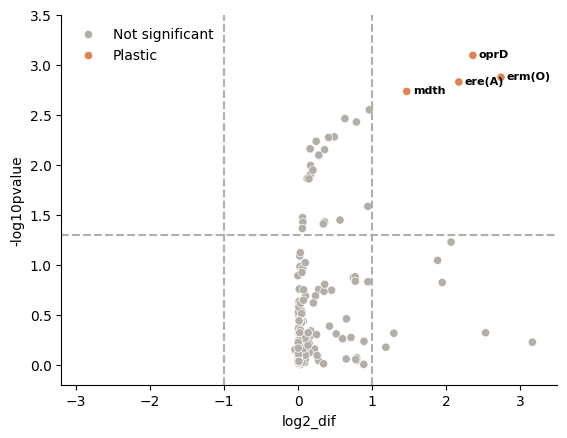

In [56]:
# Scatterplot itself
sns.scatterplot(data=graph_data, x="log2_dif", y="-log10pvalue", hue="colour", palette= palette)

# Set the scales to their most aesthetic values (this I'm doing by hand)
plt.ylim(-0.2, 3.5)
plt.xlim(-3.2, 3.5)

# Draw lines to visualize the significance thresholds
plt.axhline(y=1.3, color="#b4aea9", linestyle='--')
plt.axvline(x=1, color="#b4aea9", linestyle='--')
plt.axvline(x=-1, color="#b4aea9", linestyle='--')

# Make the legend more aesthetically pleasing
plt.legend(title= "", frameon = False)

# Despine
sns.despine()

# Add the text labels
for index in sig_df.index:
     plt.text(
         sig_df["log2_dif"][index]+0.08,
         sig_df["-log10pvalue"][index] -0.02,
         sig_df["Assay"][index],
         ha='left',
         fontsize = 8.0,
         weight='bold'
     )
# Save the plot
plt.savefig("all_ARG.png", bbox_inches= "tight", dpi = 900)

In [59]:
# SAme idea for MGEs
graph_data = pd.read_csv("all_MGE-da.csv", index_col = 0)
graph_data = graph_data[["Assay", "adjusted_pvals", "log2_dif", "log2foldchange_in", "da"]]
#graph_data = graph_data[["Assay", "adjusted_pvals", "difference_in_ncn", "log2foldchange_in", "da"]]
# Calculate the -log10 pvalues
graph_data["-log10pvalue"] = -np.log10(graph_data["adjusted_pvals"]) 
# Generate a new column with the values for the future colours
graph_data["colour"] = "Not significant"
graph_data.loc[(graph_data["da"] == True) & (graph_data["log2foldchange_in"] == "plastic"), "colour"] = "Plastic"
graph_data.loc[(graph_data["da"] == True) & (graph_data["log2foldchange_in"] == "surrounding_env"), "colour"] = "Surrounding env."
# Significant results df
sig_df = graph_data.loc[graph_data["da"] == True]
sig_df = sig_df[["Assay", "log2_dif", "-log10pvalue"]]

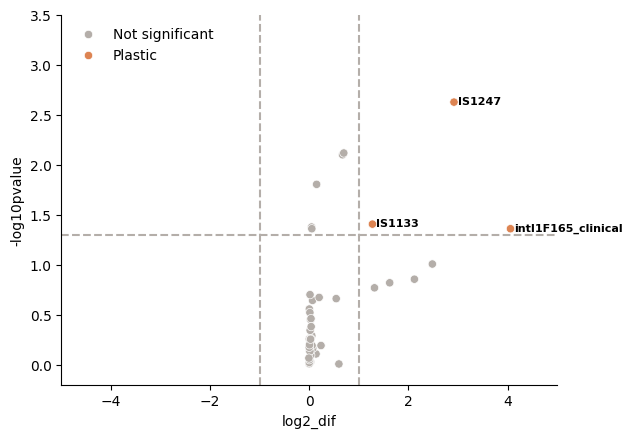

In [64]:
sns.scatterplot(data=graph_data, x="log2_dif", y="-log10pvalue", hue="colour", palette= palette)

# Set the scales to their most aesthetic values (this I'm doing by hand)
plt.ylim(-0.2, 3.5)
plt.xlim(-5, 5)

# Draw lines to visualize the significance thresholds
plt.axhline(y=1.3, color="#b4aea9", linestyle='--')
plt.axvline(x=1, color="#b4aea9", linestyle='--')
plt.axvline(x=-1, color="#b4aea9", linestyle='--')

# Make the legend more aesthetically pleasing
plt.legend(title= "", frameon = False, loc = "upper left")

# Despine
sns.despine()

# Add the text labels
for index in sig_df.index:
    plt.text(sig_df["log2_dif"][index]+0.08, sig_df["-log10pvalue"][index] -0.02,
             sig_df["Assay"][index], ha='left',
             fontsize = 8.0, weight='bold')

# Save the plot
plt.savefig("all_MGE.png", bbox_inches= "tight", dpi = 900)

In [65]:
# ARDLEY-ARGS
graph_data = pd.read_csv("ARD_ARG-da.csv", index_col = 0)
graph_data = graph_data[["Assay", "adjusted_pvals", "log2_dif", "log2foldchange_in", "da"]]
#graph_data = graph_data[["Assay", "adjusted_pvals", "difference_in_ncn", "log2foldchange_in", "da"]]
# Calculate the -log10 pvalues
graph_data["-log10pvalue"] = -np.log10(graph_data["adjusted_pvals"]) 
# Generate a new column with the values for the future colours
graph_data["colour"] = "Not significant"
graph_data.loc[(graph_data["da"] == True) & (graph_data["log2foldchange_in"] == "plastic"), "colour"] = "Plastic"
graph_data.loc[(graph_data["da"] == True) & (graph_data["log2foldchange_in"] == "surrounding_env"), "colour"] = "Surrounding env."
# Significant results df
sig_df = graph_data.loc[graph_data["da"] == True]
sig_df = sig_df[["Assay", "log2_dif", "-log10pvalue"]]

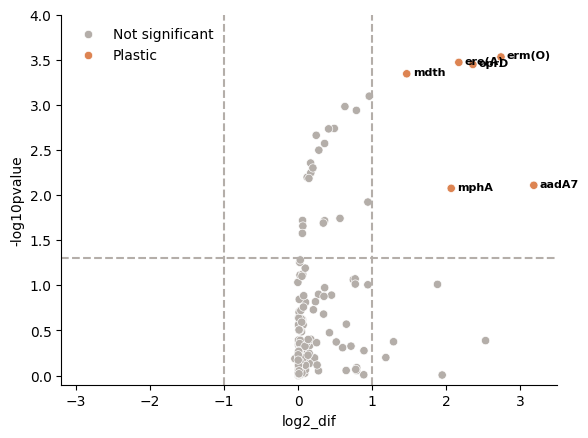

In [67]:
sns.scatterplot(data=graph_data, x="log2_dif", y="-log10pvalue", hue="colour", palette= palette)
# Set the scales to their most aesthetic values (this I'm doing by hand)
plt.ylim(-0.1, 4)
plt.xlim(-3.2, 3.5)
# Draw lines to visualize the significance thresholds
plt.axhline(y=1.3, color="#b4aea9", linestyle='--')
plt.axvline(x=1, color="#b4aea9", linestyle='--')
plt.axvline(x=-1, color="#b4aea9", linestyle='--')
# Make the legend more aesthetically pleasing
plt.legend(title= "", frameon = False, loc = "upper left")
# Despine
sns.despine()
# Add the text labels
for index in sig_df.index:
    plt.text(sig_df["log2_dif"][index]+0.08, sig_df["-log10pvalue"][index] -0.02,
             sig_df["Assay"][index], ha='left',
             fontsize = 8.0, weight='bold')
# Save the plot
plt.savefig("Ardley_ARG.png", bbox_inches= "tight", dpi = 900)

In [68]:
# ARDLEY-MGES
graph_data = pd.read_csv("ARD_MGE-da.csv", index_col = 0)
graph_data = graph_data[["Assay", "adjusted_pvals", "log2_dif", "log2foldchange_in", "da"]]
#graph_data = graph_data[["Assay", "adjusted_pvals", "difference_in_ncn", "log2foldchange_in", "da"]]
# Calculate the -log10 pvalues
graph_data["-log10pvalue"] = -np.log10(graph_data["adjusted_pvals"]) 
# Generate a new column with the values for the future colours
graph_data["colour"] = "Not significant"
graph_data.loc[(graph_data["da"] == True) & (graph_data["log2foldchange_in"] == "plastic"), "colour"] = "Plastic"
graph_data.loc[(graph_data["da"] == True) & (graph_data["log2foldchange_in"] == "surrounding_env"), "colour"] = "Surrounding env."
sig_df = graph_data.loc[graph_data["da"] == True]
sig_df = sig_df[["Assay", "log2_dif", "-log10pvalue"]]

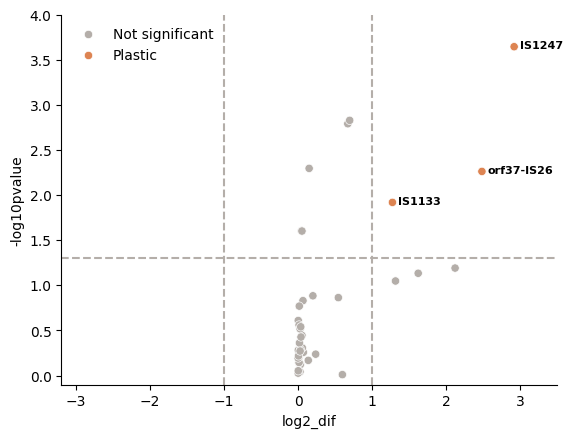

In [70]:
sns.scatterplot(data=graph_data, x="log2_dif", y="-log10pvalue", hue="colour", palette= palette)
# Set the scales to their most aesthetic values (this I'm doing by hand)
plt.ylim(-0.1, 4)
plt.xlim(-3.2, 3.5)
# Draw lines to visualize the significance thresholds
plt.axhline(y=1.3, color="#b4aea9", linestyle='--')
plt.axvline(x=1, color="#b4aea9", linestyle='--')
plt.axvline(x=-1, color="#b4aea9", linestyle='--')
# Make the legend more aesthetically pleasing
plt.legend(title= "", frameon = False, loc = "upper left")
# Despine
sns.despine()
# Add the text labels
for index in sig_df.index:
    plt.text(sig_df["log2_dif"][index]+0.08, sig_df["-log10pvalue"][index] -0.02,
             sig_df["Assay"][index], ha='left',
             fontsize = 8.0, weight='bold')
# Save the plot
plt.savefig("Ardley_MGE.png", bbox_inches= "tight", dpi = 900)

In [25]:
# LAKES-ARGS
graph_data = pd.read_csv("LAKES_ARG-da.csv", index_col = 0)
graph_data = graph_data[["Assay", "adjusted_pvals", "log2_dif", "log2foldchange_in", "da"]]
#graph_data = graph_data[["Assay", "adjusted_pvals", "difference_in_ncn", "log2foldchange_in", "da"]]
# Calculate the -log10 pvalues
graph_data["-log10pvalue"] = -np.log10(graph_data["adjusted_pvals"]) 
# Generate a new column with the values for the future colours
graph_data["colour"] = "Not significant"
graph_data.loc[(graph_data["da"] == True) & (graph_data["log2foldchange_in"] == "plastic"), "colour"] = "Plastic"
graph_data.loc[(graph_data["da"] == True) & (graph_data["log2foldchange_in"] == "surrounding_env"), "colour"] = "Surrounding env."

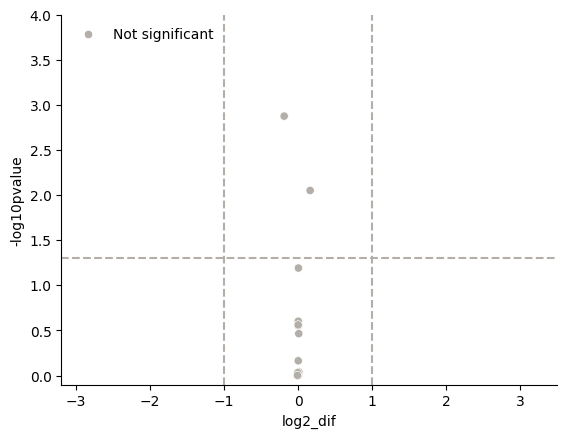

In [27]:
sns.scatterplot(data=graph_data, x="log2_dif", y="-log10pvalue", hue="colour", palette= palette)
# Set the scales to their most aesthetic values (this I'm doing by hand)
plt.ylim(-0.1, 4)
plt.xlim(-3.2, 3.5)
# Draw lines to visualize the significance thresholds
plt.axhline(y=1.3, color="#b4aea9", linestyle='--')
plt.axvline(x=1, color="#b4aea9", linestyle='--')
plt.axvline(x=-1, color="#b4aea9", linestyle='--')
# Make the legend more aesthetically pleasing
plt.legend(title= "", frameon = False, loc = "upper left")
# Despine
sns.despine()
# Save the plot
plt.savefig("Lakes_ARG.png", bbox_inches= "tight", dpi = 900)

In [28]:
# LAKES-MGEs
graph_data = pd.read_csv("LAKES_MGE-da.csv", index_col = 0)
graph_data = graph_data[["Assay", "adjusted_pvals", "log2_dif", "log2foldchange_in", "da"]]
#graph_data = graph_data[["Assay", "adjusted_pvals", "difference_in_ncn", "log2foldchange_in", "da"]]
# Calculate the -log10 pvalues
graph_data["-log10pvalue"] = -np.log10(graph_data["adjusted_pvals"]) 
# Generate a new column with the values for the future colours
graph_data["colour"] = "Not significant"
graph_data.loc[(graph_data["da"] == True) & (graph_data["log2foldchange_in"] == "plastic"), "colour"] = "Plastic"
graph_data.loc[(graph_data["da"] == True) & (graph_data["log2foldchange_in"] == "surrounding_env"), "colour"] = "Surrounding env."

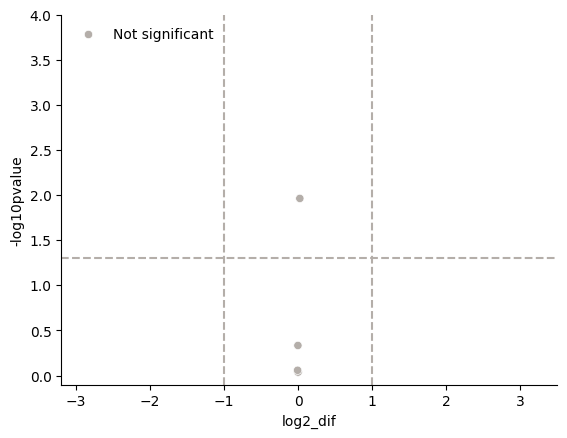

In [30]:
sns.scatterplot(data=graph_data, x="log2_dif", y="-log10pvalue", hue="colour", palette= palette)
# Set the scales to their most aesthetic values (this I'm doing by hand)
plt.ylim(-0.1, 4)
plt.xlim(-3.2, 3.5)
# Draw lines to visualize the significance thresholds
plt.axhline(y=1.3, color="#b4aea9", linestyle='--')
plt.axvline(x=1, color="#b4aea9", linestyle='--')
plt.axvline(x=-1, color="#b4aea9", linestyle='--')
# Make the legend more aesthetically pleasing
plt.legend(title= "", frameon = False, loc = "upper left")
# Despine
sns.despine()
# Save the plot
plt.savefig("Lakes_MGE.png", bbox_inches= "tight", dpi = 900)